# Neural Style Transfer with AdaIN

Based on: https://keras.io/examples/generative/adain/

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [6]:
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.15.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Defining the global variables.
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 1
AUTOTUNE = tf.data.AUTOTUNE # Optimize dataset loading

# Define path to style images
STYLE_IMAGES_DIR = "./data/best-artworks/resized/resized/"

In [ ]:
# locally downloaded images for training
def decode_and_resize(image_path):
    """Decodes and resizes an image from the image file path.

    Args:
        image_path: The image file path.

    Returns:
        A resized image.
    """
    image = tf.io.read_file(image_path) # Read the image file
    image = tf.image.decode_jpeg(image, channels=3)  # Decode as RGB image
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) # Convert to float32 for TensorFlow
    image = tf.image.resize(image, IMAGE_SIZE) # resize
    return image

# VOC Data set for content images
def extract_image_from_voc(element):
    """Extracts image from the PascalVOC dataset.

    Args:
        element: A dictionary of data.

    Returns:
        A resized image.
    """
    image = element["image"] # Get image from dataset
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


# Get the image file paths for the style images.
style_images = [os.path.join(STYLE_IMAGES_DIR, img) for img in os.listdir(STYLE_IMAGES_DIR) if img.endswith(".jpg")]

# Split the style images into train, val, and test sets
total_style_images = len(style_images)
train_style = style_images[: int(0.8 * total_style_images)] # 80% for training
val_style = style_images[int(0.8 * total_style_images) : int(0.9 * total_style_images)] # 10% for validation
test_style = style_images[int(0.9 * total_style_images) :] # 10% for testing

# Build the style dataset
# Converts image file paths into TensorFlow datasets.
# Applies decode_and_resize() to load & preprocess images.
# Uses .repeat() to ensure infinite data (useful for training).
train_style_ds = (
    tf.data.Dataset.from_tensor_slices(train_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)

val_style_ds = (
    tf.data.Dataset.from_tensor_slices(val_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)

test_style_ds = (
    tf.data.Dataset.from_tensor_slices(test_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)

# Load PascalVOC dataset for content images
train_content_ds = tfds.load("voc", split="train").map(extract_image_from_voc).repeat()
val_content_ds = tfds.load("voc", split="validation").map(extract_image_from_voc).repeat()
test_content_ds = tfds.load("voc", split="test").map(extract_image_from_voc).repeat()

# Zip the style and content datasets.
# Pair Style & Content Datasets for Training
# Pairs style images with content images (needed for style transfer training).
# Shuffles to avoid bias.
# Batches the data
train_ds = (
    tf.data.Dataset.zip((train_style_ds, train_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.zip((val_style_ds, val_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.zip((test_style_ds, test_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

2025-02-11 15:46:06.736784: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-02-11 15:46:06.736818: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-11 15:46:06.736831: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-11 15:46:06.736866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-11 15:46:06.736891: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-02-11 15:46:07.135118: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty t

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/4952 [00:00<?, ? examples/s]

Shuffling /Users/maxfrischknecht/tensorflow_datasets/voc/2007/incomplete.E1KI3J_4.0.0/voc-test.tfrecord*...:  …

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling /Users/maxfrischknecht/tensorflow_datasets/voc/2007/incomplete.E1KI3J_4.0.0/voc-train.tfrecord*...: …

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling /Users/maxfrischknecht/tensorflow_datasets/voc/2007/incomplete.E1KI3J_4.0.0/voc-validation.tfrecord*…

Dataset voc downloaded and prepared to /Users/maxfrischknecht/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


## Visualizing the data

It is always better to visualize the data before training. To ensure the correctness of our preprocessing pipeline, we visualize 10 samples from our dataset.

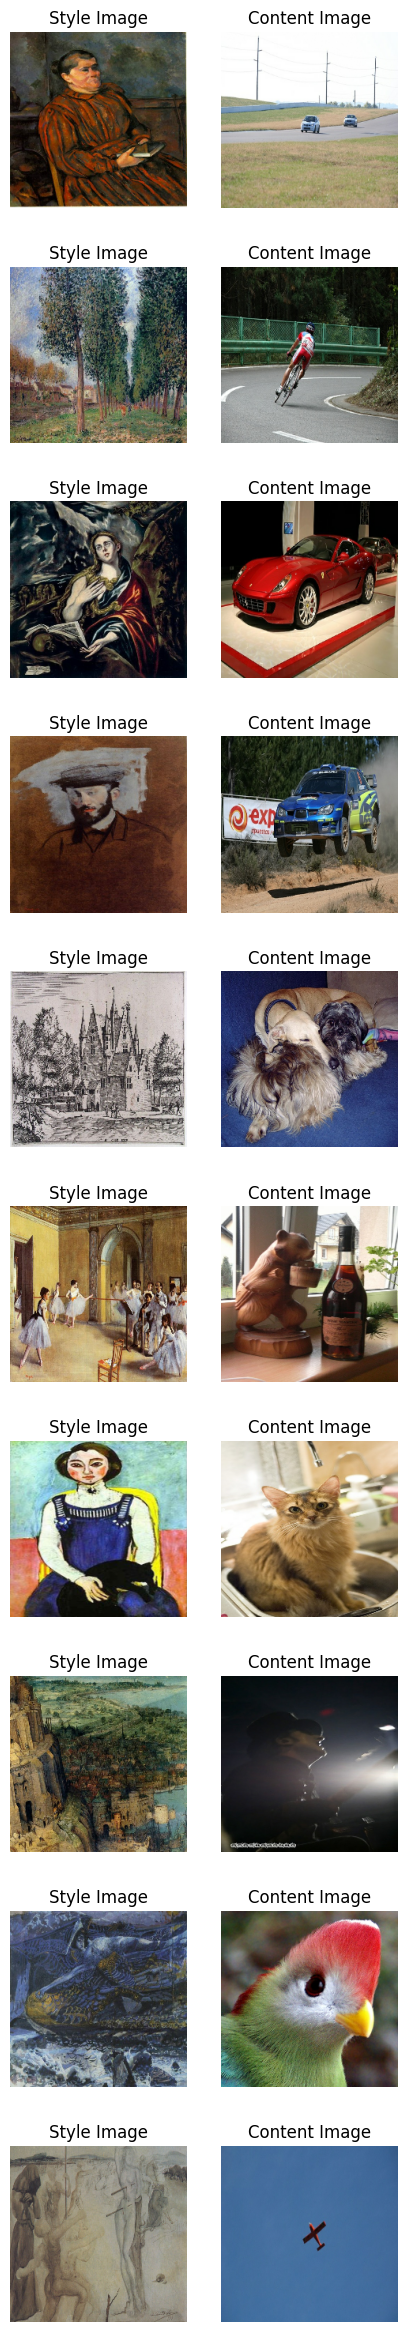

In [11]:
style, content = next(iter(train_ds))
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(5, 30))
[ax.axis("off") for ax in np.ravel(axes)]

for (axis, style_image, content_image) in zip(axes, style[0:10], content[0:10]):
    (ax_style, ax_content) = axis
    ax_style.imshow(style_image)
    ax_style.set_title("Style Image")

    ax_content.imshow(content_image)
    ax_content.set_title("Content Image")

## Architecture

The style transfer network takes a content image and a style image as inputs and outputs the style transferred image. The authors of AdaIN propose a simple encoder-decoder structure for achieving this.

The content image (C) and the style image (S) are both fed to the encoder networks. The output from these encoder networks (feature maps) are then fed to the AdaIN layer. The AdaIN layer computes a combined feature map. This feature map is then fed into a randomly initialized decoder network that serves as the generator for the neural style transferred image.

The style feature map (fs) and the content feature map (fc) are fed to the AdaIN layer. This layer produced the combined feature map t. The function g represents the decoder (generator) network

### Encoder

The encoder is a part of the pretrained (pretrained on imagenet) VGG19 model. We slice the model from the block4-conv1 layer. The output layer is as suggested by the authors in their paper.

In [12]:
def get_encoder():
    vgg19 = keras.applications.VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(*IMAGE_SIZE, 3),
    )
    vgg19.trainable = False
    mini_vgg19 = keras.Model(vgg19.input, vgg19.get_layer("block4_conv1").output)

    inputs = layers.Input([*IMAGE_SIZE, 3])
    mini_vgg19_out = mini_vgg19(inputs)
    return keras.Model(inputs, mini_vgg19_out, name="mini_vgg19")


### Adaptive Instance Normalization

In [13]:
def get_mean_std(x, epsilon=1e-5):
    axes = [1, 2]

    # Compute the mean and standard deviation of a tensor.
    mean, variance = tf.nn.moments(x, axes=axes, keepdims=True)
    standard_deviation = tf.sqrt(variance + epsilon)
    return mean, standard_deviation


def ada_in(style, content):
    """Computes the AdaIn feature map.

    Args:
        style: The style feature map.
        content: The content feature map.

    Returns:
        The AdaIN feature map.
    """
    content_mean, content_std = get_mean_std(content)
    style_mean, style_std = get_mean_std(style)
    t = style_std * (content - content_mean) / content_std + style_mean
    return t

### Decoder

In [14]:
def get_decoder():
    config = {"kernel_size": 3, "strides": 1, "padding": "same", "activation": "relu"}
    decoder = keras.Sequential(
        [
            layers.InputLayer((None, None, 512)),
            layers.Conv2D(filters=512, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=128, **config),
            layers.Conv2D(filters=128, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=64, **config),
            layers.Conv2D(
                filters=3,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="sigmoid",
            ),
        ]
    )
    return decoder


### Loss Function

In [15]:
def get_loss_net():
    vgg19 = keras.applications.VGG19(
        include_top=False, weights="imagenet", input_shape=(*IMAGE_SIZE, 3)
    )
    vgg19.trainable = False
    layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]
    outputs = [vgg19.get_layer(name).output for name in layer_names]
    mini_vgg19 = keras.Model(vgg19.input, outputs)

    inputs = layers.Input([*IMAGE_SIZE, 3])
    mini_vgg19_out = mini_vgg19(inputs)
    return keras.Model(inputs, mini_vgg19_out, name="loss_net")


## Neural Style Transfer

In [16]:
class NeuralStyleTransfer(tf.keras.Model):
    def __init__(self, encoder, decoder, loss_net, style_weight, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_net = loss_net
        self.style_weight = style_weight

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.style_loss_tracker = keras.metrics.Mean(name="style_loss")
        self.content_loss_tracker = keras.metrics.Mean(name="content_loss")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, inputs):
        style, content = inputs

        # Initialize the content and style loss.
        loss_content = 0.0
        loss_style = 0.0

        with tf.GradientTape() as tape:
            # Encode the style and content image.
            style_encoded = self.encoder(style)
            content_encoded = self.encoder(content)

            # Compute the AdaIN target feature maps.
            t = ada_in(style=style_encoded, content=content_encoded)

            # Generate the neural style transferred image.
            reconstructed_image = self.decoder(t)

            # Compute the losses.
            reconstructed_vgg_features = self.loss_net(reconstructed_image)
            style_vgg_features = self.loss_net(style)
            loss_content = self.loss_fn(t, reconstructed_vgg_features[-1])
            for inp, out in zip(style_vgg_features, reconstructed_vgg_features):
                mean_inp, std_inp = get_mean_std(inp)
                mean_out, std_out = get_mean_std(out)
                loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(
                    std_inp, std_out
                )
            loss_style = self.style_weight * loss_style
            total_loss = loss_content + loss_style

        # Compute gradients and optimize the decoder.
        trainable_vars = self.decoder.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the trackers.
        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(loss_content)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def test_step(self, inputs):
        style, content = inputs

        # Initialize the content and style loss.
        loss_content = 0.0
        loss_style = 0.0

        # Encode the style and content image.
        style_encoded = self.encoder(style)
        content_encoded = self.encoder(content)

        # Compute the AdaIN target feature maps.
        t = ada_in(style=style_encoded, content=content_encoded)

        # Generate the neural style transferred image.
        reconstructed_image = self.decoder(t)

        # Compute the losses.
        recons_vgg_features = self.loss_net(reconstructed_image)
        style_vgg_features = self.loss_net(style)
        loss_content = self.loss_fn(t, recons_vgg_features[-1])
        for inp, out in zip(style_vgg_features, recons_vgg_features):
            mean_inp, std_inp = get_mean_std(inp)
            mean_out, std_out = get_mean_std(out)
            loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(
                std_inp, std_out
            )
        loss_style = self.style_weight * loss_style
        total_loss = loss_content + loss_style

        # Update the trackers.
        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(loss_content)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    @property
    def metrics(self):
        return [
            self.style_loss_tracker,
            self.content_loss_tracker,
            self.total_loss_tracker,
        ]


## Train Monitor callback

In [17]:
test_style, test_content = next(iter(test_ds))


class TrainMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Encode the style and content image.
        test_style_encoded = self.model.encoder(test_style)
        test_content_encoded = self.model.encoder(test_content)

        # Compute the AdaIN features.
        test_t = ada_in(style=test_style_encoded, content=test_content_encoded)
        test_reconstructed_image = self.model.decoder(test_t)

        # Plot the Style, Content and the NST image.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(tf.keras.utils.array_to_img(test_style[0]))
        ax[0].set_title(f"Style: {epoch:03d}")

        ax[1].imshow(tf.keras.utils.array_to_img(test_content[0]))
        ax[1].set_title(f"Content: {epoch:03d}")

        ax[2].imshow(
            tf.keras.utils.array_to_img(test_reconstructed_image[0])
        )
        ax[2].set_title(f"NST: {epoch:03d}")

        plt.show()
        plt.close()

## Train the model

Epoch 1/5
50/50 [==============================] - ETA: 0s - style_loss: 224.6825 - content_loss: 148.4971 - total_loss: 373.1795

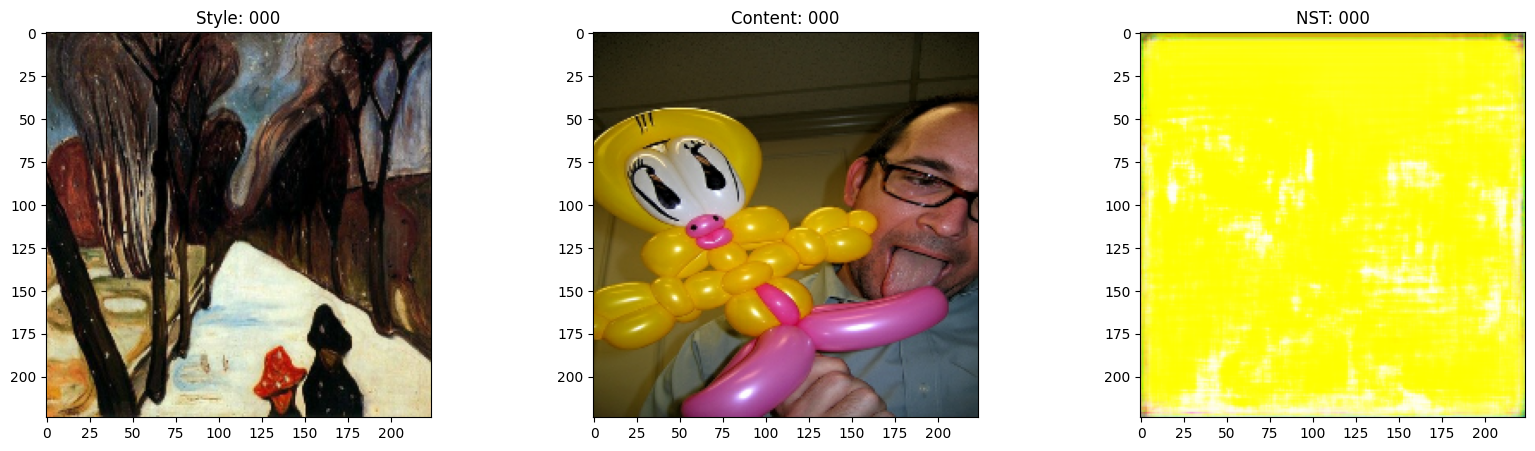

50/50 [==============================] - 544s 11s/step - style_loss: 224.6825 - content_loss: 148.4971 - total_loss: 373.1795 - val_style_loss: 193.3588 - val_content_loss: 135.9011 - val_total_loss: 329.2599
Epoch 2/5
50/50 [==============================] - ETA: 0s - style_loss: 183.1911 - content_loss: 131.5860 - total_loss: 314.7771

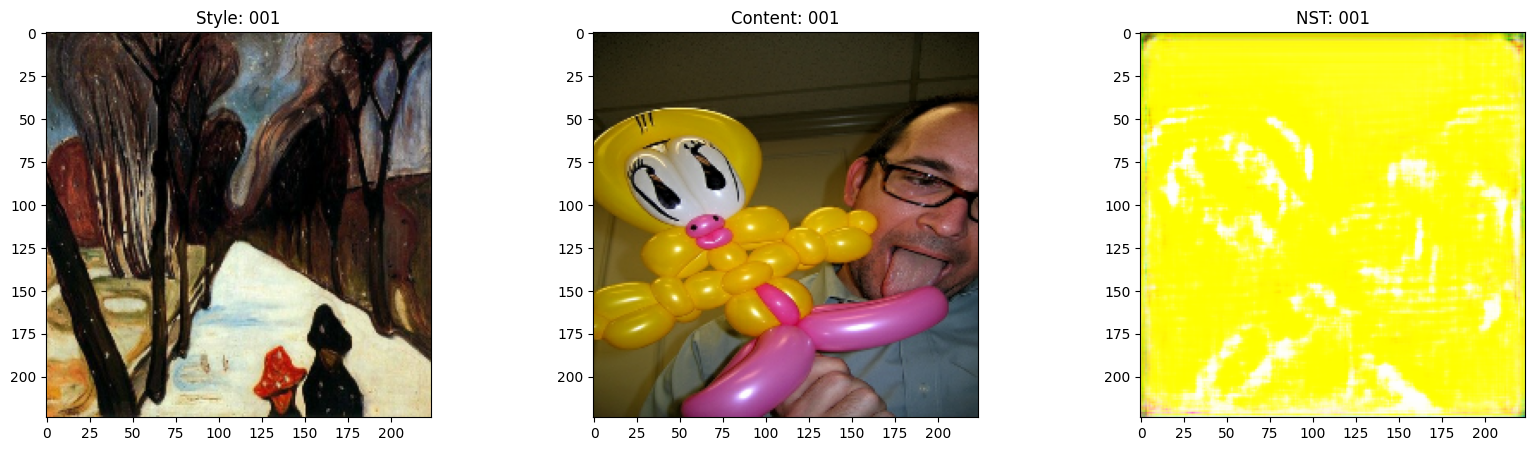

50/50 [==============================] - 500s 10s/step - style_loss: 183.1911 - content_loss: 131.5860 - total_loss: 314.7771 - val_style_loss: 166.6380 - val_content_loss: 124.4110 - val_total_loss: 291.0489
Epoch 3/5
50/50 [==============================] - ETA: 0s - style_loss: 156.1243 - content_loss: 121.6984 - total_loss: 277.8227

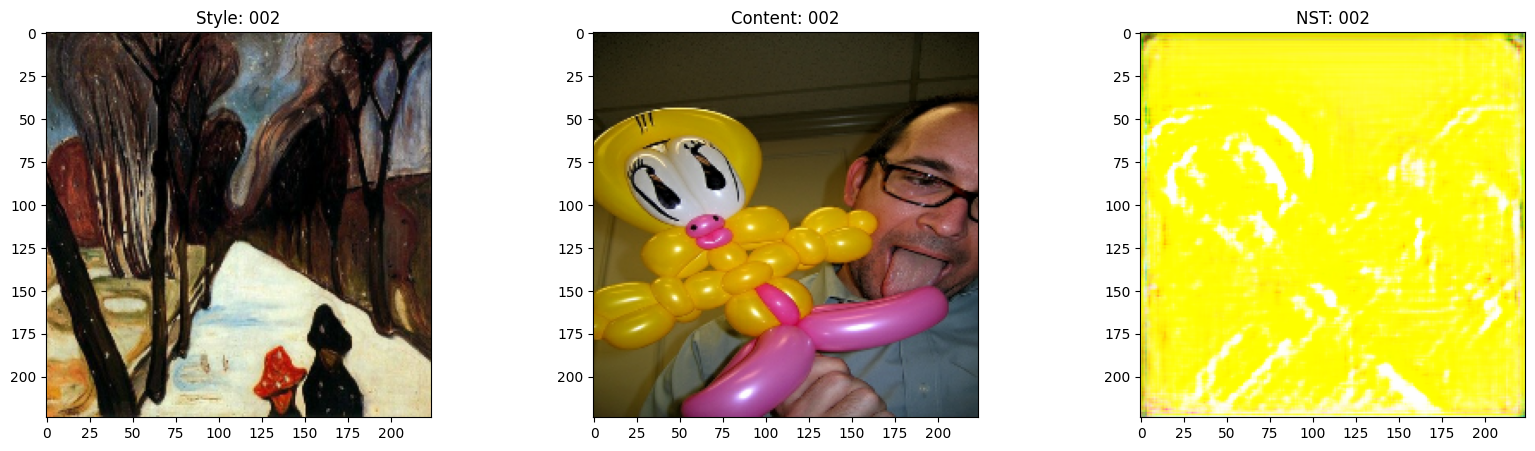

50/50 [==============================] - 514s 10s/step - style_loss: 156.1243 - content_loss: 121.6984 - total_loss: 277.8227 - val_style_loss: 141.2937 - val_content_loss: 115.4344 - val_total_loss: 256.7281
Epoch 4/5
50/50 [==============================] - ETA: 0s - style_loss: 139.0366 - content_loss: 115.6282 - total_loss: 254.6647

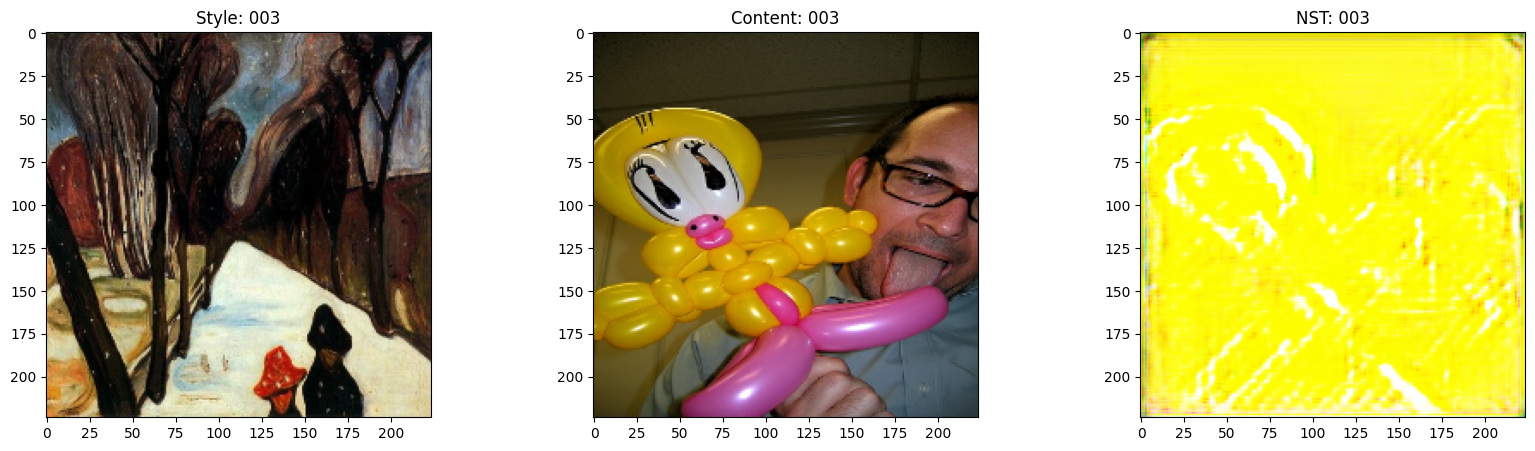

50/50 [==============================] - 512s 10s/step - style_loss: 139.0366 - content_loss: 115.6282 - total_loss: 254.6647 - val_style_loss: 129.7892 - val_content_loss: 110.6857 - val_total_loss: 240.4750
Epoch 5/5
50/50 [==============================] - ETA: 0s - style_loss: 127.6130 - content_loss: 111.0379 - total_loss: 238.6509

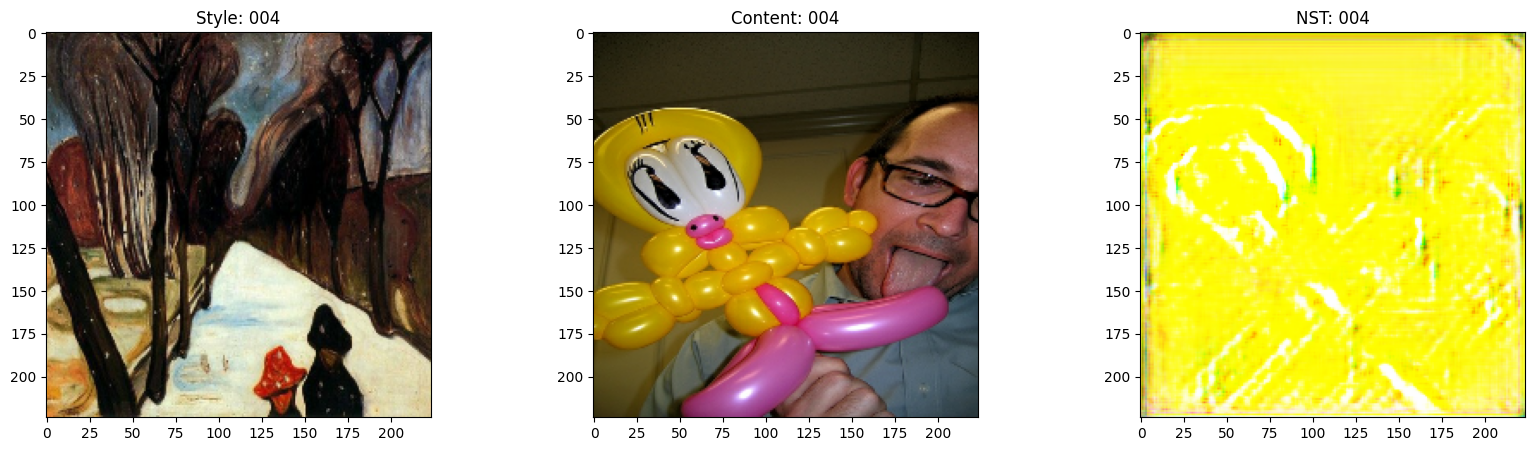

50/50 [==============================] - 514s 10s/step - style_loss: 127.6130 - content_loss: 111.0379 - total_loss: 238.6509 - val_style_loss: 121.6565 - val_content_loss: 107.2316 - val_total_loss: 228.8881


In [20]:
optimizer = keras.optimizers.legacy.Adam(learning_rate=1e-5)
loss_fn = keras.losses.MeanSquaredError()

encoder = get_encoder()
loss_net = get_loss_net()
decoder = get_decoder()

model = NeuralStyleTransfer(
    encoder=encoder, decoder=decoder, loss_net=loss_net, style_weight=4.0
)

model.compile(optimizer=optimizer, loss_fn=loss_fn)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=50,
    validation_data=val_ds, 
    validation_steps=50,
    callbacks=[TrainMonitor()],
)

## Inference

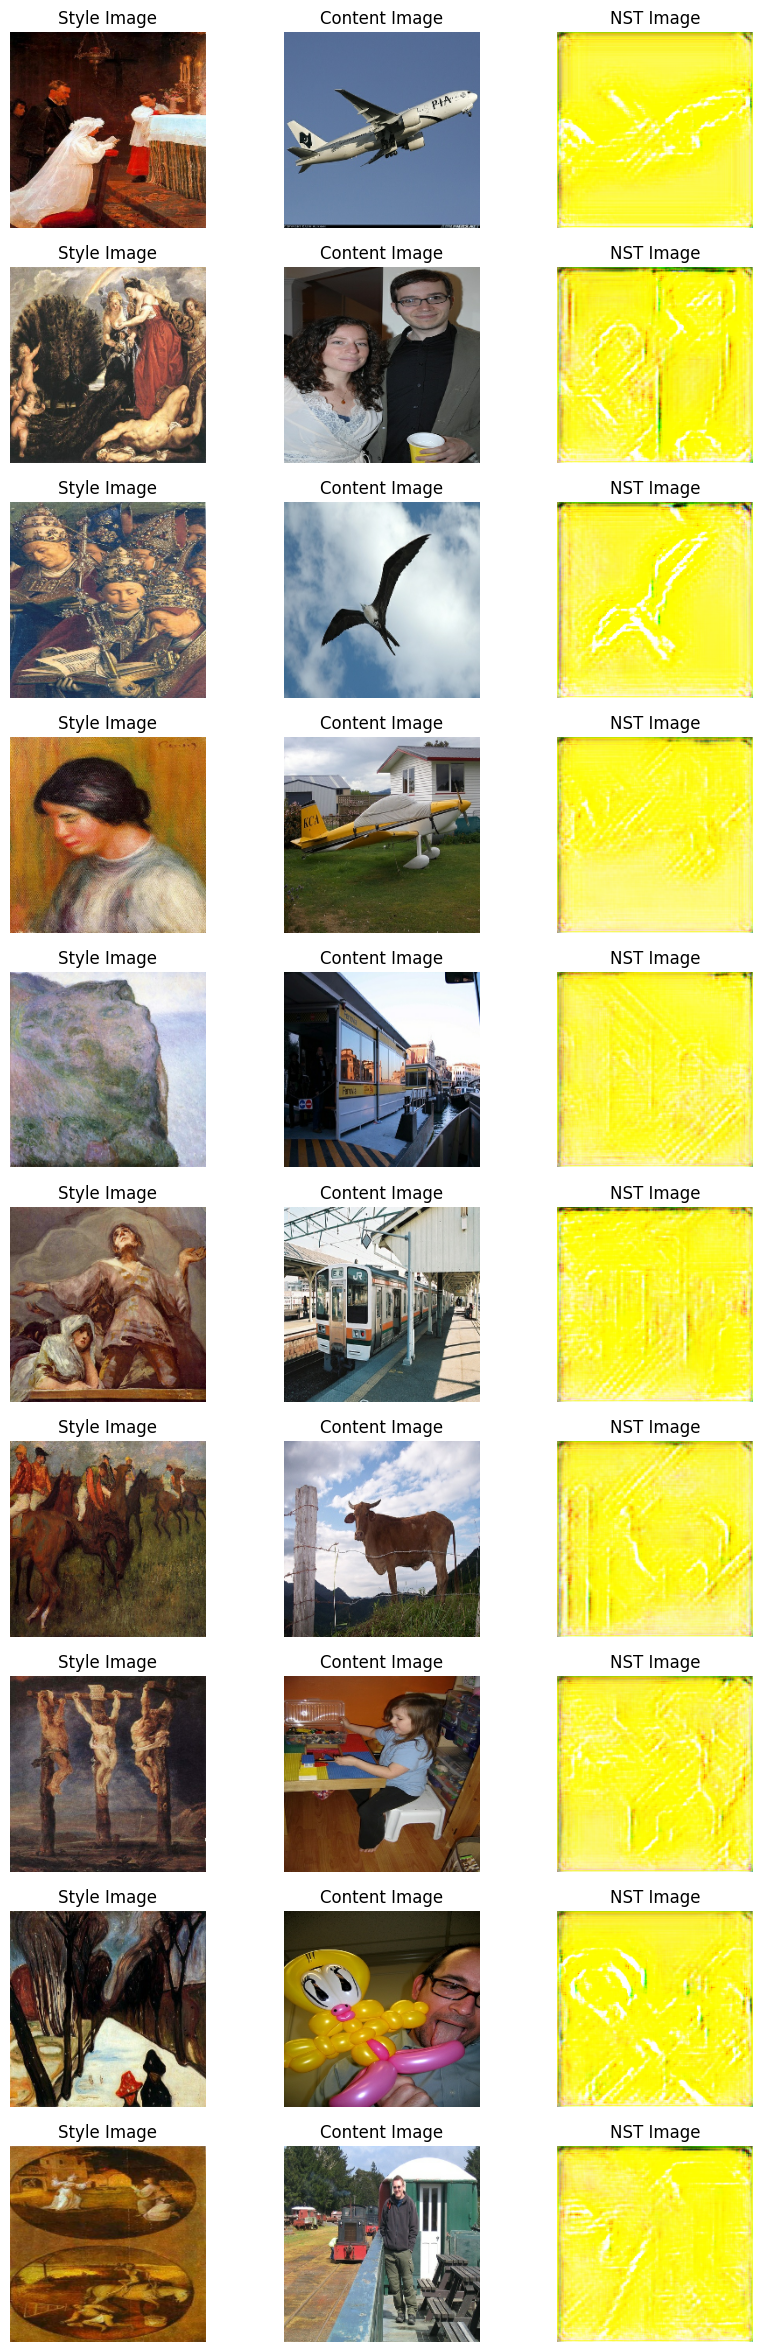

In [21]:
for style, content in test_ds.take(1):
    style_encoded = model.encoder(style)
    content_encoded = model.encoder(content)
    t = ada_in(style=style_encoded, content=content_encoded)
    reconstructed_image = model.decoder(t)
    fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(10, 30))
    [ax.axis("off") for ax in np.ravel(axes)]

    for axis, style_image, content_image, reconstructed_image in zip(
        axes, style[0:10], content[0:10], reconstructed_image[0:10]
    ):
        (ax_style, ax_content, ax_reconstructed) = axis
        ax_style.imshow(style_image)
        ax_style.set_title("Style Image")
        ax_content.imshow(content_image)
        ax_content.set_title("Content Image")
        ax_reconstructed.imshow(reconstructed_image)
        ax_reconstructed.set_title("NST Image")


In [25]:
class NeuralStyleTransfer(keras.Model):
    def __init__(self, encoder, decoder, loss_net, style_weight=4.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_net = loss_net
        self.style_weight = style_weight

    def call(self, inputs):
        # Define the forward pass logic
        pass  # Replace with your actual forward pass code

    def get_config(self):
        """Returns the config dictionary for model serialization."""
        config = super().get_config()
        config.update({
            "style_weight": self.style_weight
        })
        return config

    @classmethod
    def from_config(cls, config):
        """Reconstructs the model from config."""
        return cls(**config)

model.save("style_transfer_model.keras")  # Saves in Keras format